# Validation of SONIC paradigm for multi-compartmental approaches

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from PySONIC.utils import logger, bounds, isWithin
from PySONIC.threshold import threshold
from PySONIC.neurons import getPointNeuron, passiveNeuron, MRGNode, SundtSegment
from PySONIC.plt import setNormalizer
from PySONIC.core import BilayerSonophore, AcousticDrive, ElectricDrive, PulsedProtocol, Lookup

from ExSONIC.core import MRGFiber, SennFiber, UnmyelinatedFiber, IntracellularCurrent, GaussianAcousticSource
from ExSONIC.core.benchmark import *
from ExSONIC.constants import THR_VM_DIV

logger.setLevel(logging.INFO)

## Parameters

In [3]:
root = 'benchmarkData'
nperax = 20
f_US = 500.  # kHz
A_US = 500.  # kPa
fwhm = 1.0  # Gaussian FWHM (mm)
freqs = np.logspace(np.log10(20.), np.log10(4000.), nperax)  # kHz
amps = np.logspace(0, 3, 20)  # kPa
tstop_active = 3.0  # ms
figs = {}

## Pre-step 1: mapping of acoustic amplitude to Cm oscillation range

Using a 32 nm radius sonophore at 500 kHz

 03/08/2020 17:46:15: gamma range: 0 - 1 -


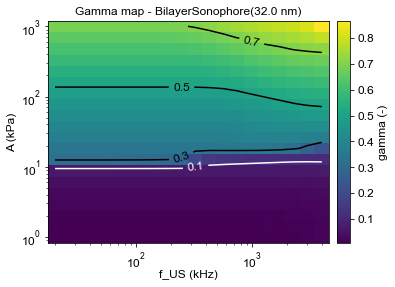

In [23]:
bls = BilayerSonophore(32e-9, 1e-2, 0.)
gamma_map = GammaMap(root, bls, freqs, amps)
gamma_map.run()
gamma_lookup = Lookup({'f': gamma_map.xvec, 'A': np.hstack(([0.], gamma_map.yvec))}, {'gamma': np.vstack([np.zeros(gamma_map.xvec.size), gamma_map.getOutput()]).T})
#gamma_lookup.toPickle(os.path.join(root, 'gamma_lkp_bls32nm_f_US20.0kHz-4.0kkHz_20_A1.0kPa-1.0kkPa_20.lkp'))
fig = gamma_map.render()
figs['gamma_map'] = fig

In [5]:
# Inteprolate max gamma and 100 kPa equivalent gamma for 100% sonophore coverage
gamma_ub = 0.8
gamma_default = 0.5
gamma_pair = (gamma_default, 0)  # (-)
gammas = np.linspace(0.05, gamma_ub, nperax)  # (-)

## Pre-step 2: correct the MRG node to account for internodal leakage conductance

In the absence of juxtaposed internodes, the isolated MRG node membrane dynamics exhibits spontaneous activity, a behavior that prevents proper study of steady-state behavior and estimation of excitation thresholds.

To overcome this limitation, we design here a "corrected" MRG node that contains an additional internodal leakage current mimicking the influence of the neighboring indernode and to limit deviations from resting potential and eventually preventing spontaneous activity.

The reversal potential of this internodal leakage current is set to -80 mV (identical to the reversal of leakage currents in internodal sections), and its conductance is chosen that yields a similar node excitation threshold to a 100 us intracellular current pulse as that of a 10 um diameter fiber model.

In [6]:
def correctedMRGNode(g):

    class CorrectedMRGNode(MRGNode):

        name = 'corrected_MRGnode'
        gInter = g  # S/m2
        EInter = -80.0   # mV

        @classmethod
        def iInter(cls, Vm):
            ''' axial leakage current '''
            return cls.gInter * (Vm - cls.EInter)  # mA/m2

        @classmethod
        def currents(cls):
            ''' updated currents dictionary '''
            return {**MRGNode.currents(), 'iInter': lambda Vm, _: cls.iInter(Vm)}

    return CorrectedMRGNode

def isExcited(gInter, drive, pp):
    logger.info(f'simulation with gInter = {gInter:.2e} S/m2')
    pneuron = correctedMRGNode(gInter)()
    return pneuron.isExcited(pneuron.simulate(drive, pp)[0])

fiber = MRGFiber(10e-6, 11)
pp = PulsedProtocol(tstim=100e-6, toffset=3e-3)
Ithr = fiber.titrate(IntracellularCurrent(fiber.central_ID, None), pp)  # A
Am = fiber.nodes[fiber.central_ID].Am  # cm2
ithr = (Ithr * 1e3) / (Am * 1e-4)  # mA/m2
logger.info(f'Ithr = {Ithr * 1e9:.2f} nA, Am = {Am:.2e} cm2 -> ithr = {ithr:.2e} mA/m2')
drive = ElectricDrive(ithr)
gInter = threshold(lambda x: not isExcited(x, drive, pp), (1e-3, 1e6))
logger.info(f'Internodal conductance to match threshold: gInter = {gInter:.2e} S/m2')
corrected_MRGNode = correctedMRGNode(gInter)()

 29/07/2020 21:13:30: MRGFiber(fiberD = 10.0 um, 11 nodes): simulation @ IntracellularCurrent(sec_id=node5, I=10.0pA, mode=anode), tstim = 100us, toffset = 3ms
 29/07/2020 21:13:32: MRGFiber(fiberD = 10.0 um, 11 nodes): simulation @ IntracellularCurrent(sec_id=node5, I=20.0pA, mode=anode), tstim = 100us, toffset = 3ms
 29/07/2020 21:13:35: MRGFiber(fiberD = 10.0 um, 11 nodes): simulation @ IntracellularCurrent(sec_id=node5, I=40.0pA, mode=anode), tstim = 100us, toffset = 3ms
 29/07/2020 21:13:37: MRGFiber(fiberD = 10.0 um, 11 nodes): simulation @ IntracellularCurrent(sec_id=node5, I=80.0pA, mode=anode), tstim = 100us, toffset = 3ms
 29/07/2020 21:13:38: MRGFiber(fiberD = 10.0 um, 11 nodes): simulation @ IntracellularCurrent(sec_id=node5, I=160.0pA, mode=anode), tstim = 100us, toffset = 3ms
 29/07/2020 21:13:40: MRGFiber(fiberD = 10.0 um, 11 nodes): simulation @ IntracellularCurrent(sec_id=node5, I=320.0pA, mode=anode), tstim = 100us, toffset = 3ms
 29/07/2020 21:13:41: MRGFiber(fiberD 

## Point-neurons and fiber models

In [7]:
pneurons = {
    'MRG': corrected_MRGNode,
    'Sundt': SundtSegment()
}

fibers = {
    'MRG': MRGFiber(10e-6, 11),
    'Sundt': UnmyelinatedFiber(0.8e-6)
}

## Estimation of gamma sets for axon benchmarks

In [16]:
def getGammaDist(fiber, source, key='node'):
    amps = source.computeDistributedAmps(fiber)[key] * 1e-3  # kPa
    return gamma_lookup.project('f', f_US).interpVar1D(amps, 'gamma')

def getMaxPair(x, criterion='average'):
    imax =  {
        'average': np.nanargmax(x[1:] + x[:-1]),
        'gradient': np.nanargmax(np.diff(np.abs(x)))
    }[criterion]
    return np.sort(x[imax:imax + 2])[::-1]

gaussian_source = GaussianAcousticSource(
    0., GaussianAcousticSource.from_FWHM(fwhm * 1e-3), f_US * 1e3, A_US * 1e3)
sundt_gamma_dist = getGammaDist(fibers['Sundt'], gaussian_source)
sundt_gamma_pairs = {k: getMaxPair(sundt_gamma_dist, criterion=k) for k in ['average', 'gradient']}
for k, v in sundt_gamma_pairs.items():
    logger.info(f'highest {k} gamma-pair: {v}')

 29/07/2020 21:27:06: highest average gamma-pair: [0.64002517 0.63988514]
 29/07/2020 21:27:06: highest gradient gamma-pair: [0.34626948 0.26417099]


## Benchmark 1: SONIC accuracy for a passive model as a function of membrane and axial properties

Using a passive model and a "typical" sinusoidal drive (f = 500 kHz, A_Cm = 0.8 * Cm0) and a passive model, we evaluate the divergence of the SONIC output from a cycle-averaged full output (measured as the absolute difference in steady-state charge densities normalized by resting capacitance (in mV) for a combination of:
- membrane time constant (tau_m = cm / gpas)
- "axial coupling time constant" (tau_ax = cm / ga).

Objective: establish trends of SONIC divergence as a function of model parameters
and identify "safe" regions for the SONIC approximation.

### Passive properties: peripheral fibers

In [8]:
gax = {k: fiber.ga_node_to_node * 1e4 for k, fiber in fibers.items()}  # S/m2
gm = {
    'MRG': corrected_MRGNode.gLeak + corrected_MRGNode.gInter,  # S/m2
    'Sundt': SundtSegment().gLeak  # S/m2
}

taum_range = np.logspace(-4, 1, nperax)   # ms
tauax_range = np.logspace(-4, 1, nperax)   # ms
pneuron = passiveNeuron(1e-2, 1e0, -70.0)

def plotPassiveDivMap(sb, taum_range, tauax_range):
    # Build and run divmap batch
    divmap = TauDivergenceMap(root, sb, 'end', taum_range, tauax_range)
    divmap.run()
    
    # Render div map
    fig = divmap.render(interactive=True, dVmax=THR_VM_DIV)

    # Add insets to represent fiber models
    ax = fig.axes[0]
    axis_to_data = ax.transAxes + ax.transData.inverted()
    data_to_axis = axis_to_data.inverted()
    xyoffset = {'MRG': np.array([0.1, 0.15]), 'Sundt': np.array([-0.1, 0.15])}
    for k in fibers.keys():
        taum = pneurons[k].Cm0 / gm[k]   # s
        tauax = pneurons[k].Cm0 / gax[k]  # s
        print(f'{k} model: tau_m = {taum * 1e3:.2e} ms, tau_ax = {tauax * 1e3:.2e}ms')
        xy = data_to_axis.transform((taum * 1e3, tauax * 1e3))
        ax.scatter(*xy, transform=ax.transAxes, facecolor='k', edgecolor='none', linestyle='--', lw=1);
        ax.annotate(k, xy=xy, xytext=np.array(xy) + xyoffset[k], xycoords=ax.transAxes,
                    fontsize=12, arrowprops={'facecolor': 'black', 'arrowstyle': '-'},
                    horizontalalignment='left' if xyoffset[k][0] > 0 else 'right')
    xyTUS = data_to_axis.transform((1 / f_US, 1 / f_US))
    for i, k in enumerate(['horizontal', 'vertical']):
        getattr(ax, f'ax{k[0]}line')(1 / f_US, color='k', linestyle='-', linewidth=1)
        xy = np.empty(2)
        xy_offset = np.empty(2)
        xy[i] = xyTUS[i]
        xy[1 - i] = 0.
        xy_offset[i] = 0.
        xy_offset[1 - i] = 0.2
        ax.annotate('$T_{US}$', xy=xy, xytext=xy - xy_offset, xycoords=ax.transAxes, fontsize=12,
                    arrowprops={'facecolor': 'black', 'arrowstyle': '-'}, **{f'{k}alignment': 'center'})
    figs[divmap.corecode()] = fig
    return fig

### Default divergence map: gamma = (0.6, 0.4)

 29/07/2020 10:44:11: dV range: 0 - 13 mV
 29/07/2020 10:44:11: Minimal dV (0 mV) is below defined lower bound (0 mV)
 29/07/2020 10:44:11: Maximal dV (13 mV) is above defined upper bound (10 mV)
MRG model: tau_m = 3.67e-03 ms, tau_ax = 4.56e-03ms
Sundt model: tau_m = 1.00e+01 ms, tau_ax = 2.38e-02ms


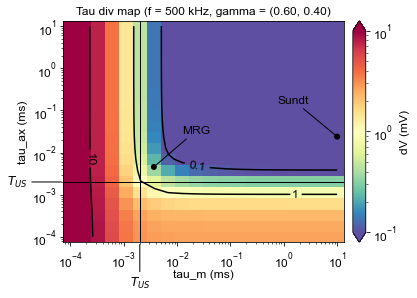

In [9]:
sb = SonicBenchmark(pneuron, 0., f_US, (0.6, 0.4))
fig = plotPassiveDivMap(sb, taum_range, tauax_range)

### Varying oscillation amplitudes

 29/07/2020 10:44:38: dV range: 0 - 9 mV
 29/07/2020 10:44:38: Minimal dV (0 mV) is below defined lower bound (0 mV)
MRG model: tau_m = 3.67e-03 ms, tau_ax = 4.56e-03ms
Sundt model: tau_m = 1.00e+01 ms, tau_ax = 2.38e-02ms


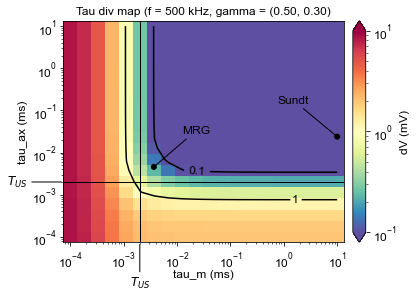

In [10]:
sb = SonicBenchmark(pneuron, 0., f_US, (0.5, 0.3))
fig = plotPassiveDivMap(sb, taum_range, tauax_range)

 29/07/2020 10:44:40: dV range: 0 - 19 mV
 29/07/2020 10:44:40: Minimal dV (0 mV) is below defined lower bound (0 mV)
 29/07/2020 10:44:40: Maximal dV (19 mV) is above defined upper bound (10 mV)
MRG model: tau_m = 3.67e-03 ms, tau_ax = 4.56e-03ms
Sundt model: tau_m = 1.00e+01 ms, tau_ax = 2.38e-02ms


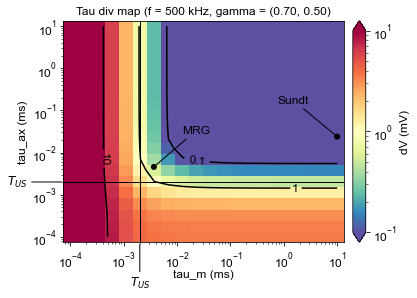

In [11]:
sb = SonicBenchmark(pneuron, 0., f_US, (0.7, 0.5))
fig = plotPassiveDivMap(sb, taum_range, tauax_range)

### Varying oscillation amplitude gradients

 29/07/2020 10:45:24: dV range: 0 - 11 mV
 29/07/2020 10:45:24: Minimal dV (0 mV) is below defined lower bound (0 mV)
 29/07/2020 10:45:24: Maximal dV (11 mV) is above defined upper bound (10 mV)
MRG model: tau_m = 3.67e-03 ms, tau_ax = 4.56e-03ms
Sundt model: tau_m = 1.00e+01 ms, tau_ax = 2.38e-02ms


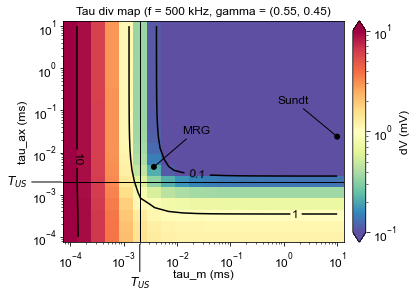

In [12]:
sb = SonicBenchmark(pneuron, 0., f_US, (0.55, 0.45))
fig = plotPassiveDivMap(sb, taum_range, tauax_range)

 29/07/2020 10:45:25: dV range: 0 - 19 mV
 29/07/2020 10:45:25: Minimal dV (0 mV) is below defined lower bound (0 mV)
 29/07/2020 10:45:25: Maximal dV (19 mV) is above defined upper bound (10 mV)
MRG model: tau_m = 3.67e-03 ms, tau_ax = 4.56e-03ms
Sundt model: tau_m = 1.00e+01 ms, tau_ax = 2.38e-02ms


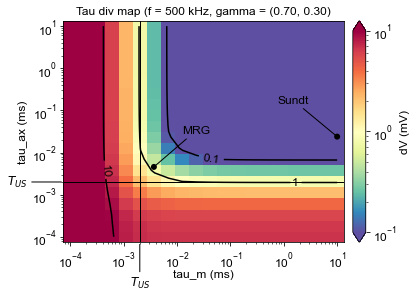

In [13]:
sb = SonicBenchmark(pneuron, 0., f_US, (0.7, 0.3))
fig = plotPassiveDivMap(sb, taum_range, tauax_range)

### Varying oscillation frequencies

 29/07/2020 10:45:46: dV range: 0 - 14 mV
 29/07/2020 10:45:46: Minimal dV (0 mV) is below defined lower bound (0 mV)
 29/07/2020 10:45:46: Maximal dV (14 mV) is above defined upper bound (10 mV)
MRG model: tau_m = 3.67e-03 ms, tau_ax = 4.56e-03ms
Sundt model: tau_m = 1.00e+01 ms, tau_ax = 2.38e-02ms


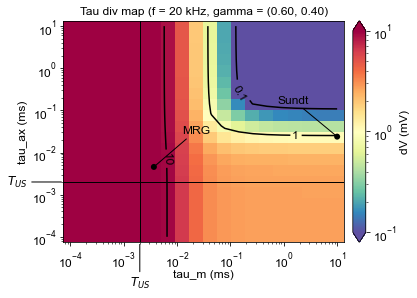

In [14]:
sb = SonicBenchmark(pneuron, 0., 20., (0.6, 0.4))
fig = plotPassiveDivMap(sb, taum_range, tauax_range)

 29/07/2020 10:45:50: dV range: 0 - 11 mV
 29/07/2020 10:45:50: Minimal dV (0 mV) is below defined lower bound (0 mV)
 29/07/2020 10:45:50: Maximal dV (11 mV) is above defined upper bound (10 mV)
MRG model: tau_m = 3.67e-03 ms, tau_ax = 4.56e-03ms
Sundt model: tau_m = 1.00e+01 ms, tau_ax = 2.38e-02ms


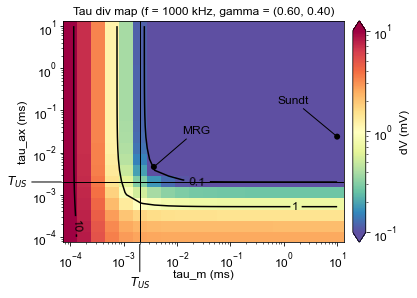

In [15]:
sb = SonicBenchmark(pneuron, 0., 1000., (0.6, 0.4))
fig = plotPassiveDivMap(sb, taum_range, tauax_range)

## Benchmark 2: SONIC accuracy for realistic bi-compartmental models as a function of drive parameters

Compute the average SONIC divergence for varying US frequencies and amplitude gradients, using full membrane dynamics and specific axial coupling magnitudes of specific neurons: 
- two nodes of Ranvier (MRG membrane dynamics with added leakage axial conductance mimicking the influence of internodal segments on membrane dynamics) of a myelinated fiber separated by a full internode
- two typical segments of an unmyelinated fiber (Sundt membrane dynamics) directly coupled

Objective: determine the drive parametric sub-space of SONIC applicability for each model.

In [21]:
def plotDriveDivMap(key, tstop, insets=None):
    ga = fibers[key].ga_node_to_node * 1e3
    sb = SonicBenchmark(pneurons[key], ga, f_US, gamma_pair)
    divmap = DriveDivergenceMap(root, sb, 'avg', freqs, gammas, tstop=tstop)
    divmap.run()
    fig = divmap.render(interactive=True, dVmax=THR_VM_DIV, thresholds=True)
    fig.axes[0].set_title(f'{key} model divergence map')
    figs[f'{key}_map'] = fig
    if insets is not None:
        for f, gamma in insets:
            fig.axes[0].scatter(f, gamma, facecolor='k', edgecolor='none', linestyle='-', lw=1)
            sb = SonicBenchmark(pneurons[key], ga, f, (gamma, 0.))
            t, sol = sb.sim(tstop)
            insetfig = sb.plotV(t, sol)
            insetfig.axes[0].set_title(f'{key} model - f = {f:.0f} kHz, $\\gamma$ = {gamma:.2f}')
            for item in ['top', 'right']:
                insetfig.axes[0].spines[item].set_visible(False)
            figs[f'{key}_inset_{f:.0f}kHz_gamma{gamma:.2f}_V'] = insetfig

### MRG node

 20/07/2020 18:30:35: dV range: 0 - 50 mV
 20/07/2020 18:30:35: Minimal dV (0 mV) is below defined lower bound (0 mV)
 20/07/2020 18:30:35: Maximal dV (50 mV) is above defined upper bound (10 mV)
 20/07/2020 18:30:36: SonicBenchmark(corrected_MRGnode dynamics, ga = 4.39e+02 mS/cm2, f = 50 kHz, rel A_Cm = (0.35, 0.00)): 1.00 ms simulation
 20/07/2020 18:30:38: SonicBenchmark(corrected_MRGnode dynamics, ga = 4.39e+02 mS/cm2, f = 50 kHz, rel A_Cm = (0.65, 0.00)): 1.00 ms simulation
 20/07/2020 18:30:42: SonicBenchmark(corrected_MRGnode dynamics, ga = 4.39e+02 mS/cm2, f = 300 kHz, rel A_Cm = (0.30, 0.00)): 1.00 ms simulation
 20/07/2020 18:30:48: SonicBenchmark(corrected_MRGnode dynamics, ga = 4.39e+02 mS/cm2, f = 300 kHz, rel A_Cm = (0.70, 0.00)): 1.00 ms simulation
 20/07/2020 18:31:01: SonicBenchmark(corrected_MRGnode dynamics, ga = 4.39e+02 mS/cm2, f = 600 kHz, rel A_Cm = (0.50, 0.00)): 1.00 ms simulation
 20/07/2020 18:31:16: SonicBenchmark(corrected_MRGnode dynamics, ga = 4.39e+02 mS

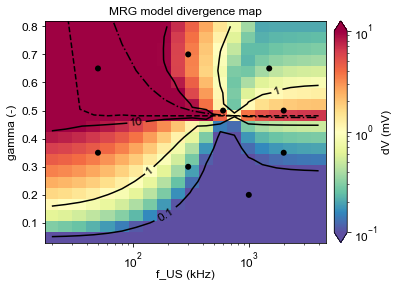

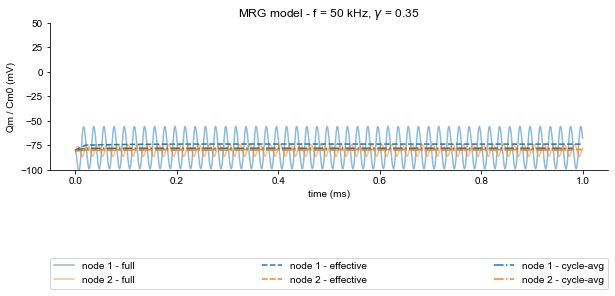

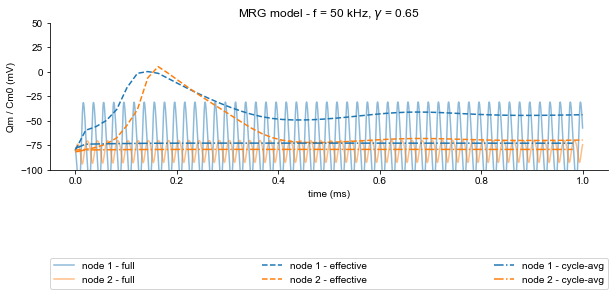

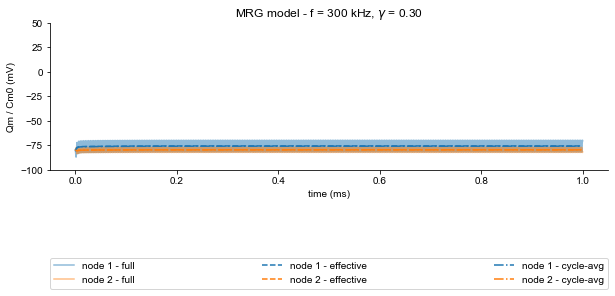

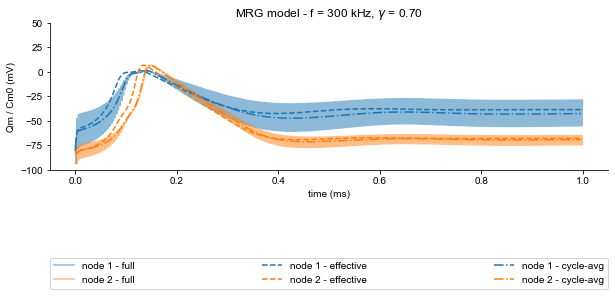

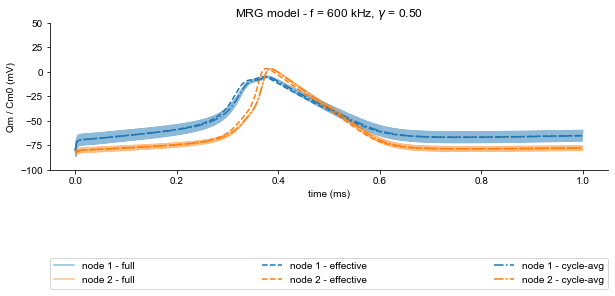

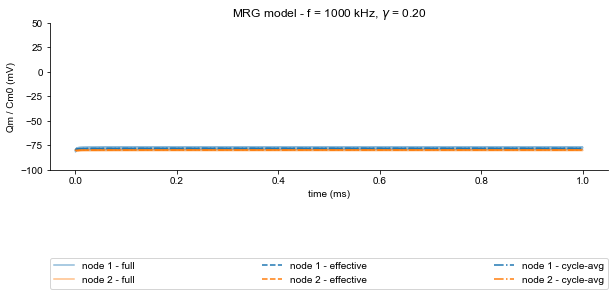

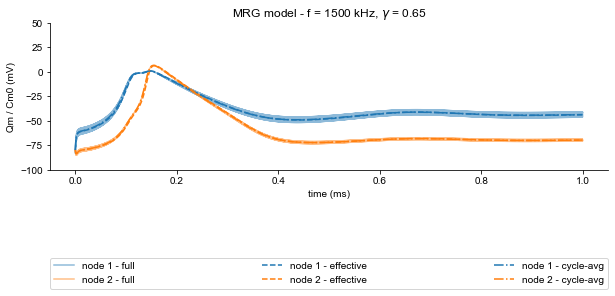

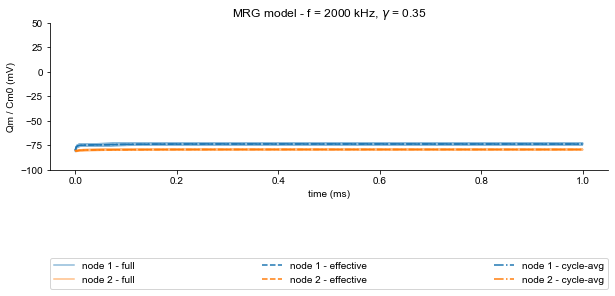

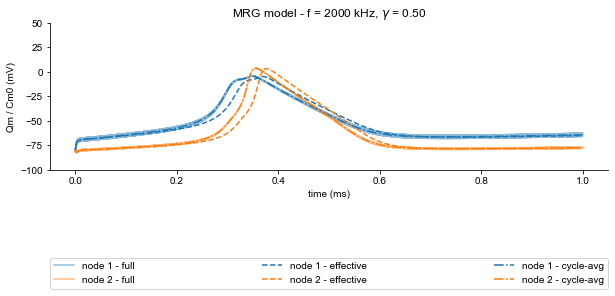

In [28]:
insets = [
    (50., 0.35),
    (50., 0.65),
    (300., 0.3),
    (300., 0.7),
    (600, 0.5),
    (1000., 0.2),
    (1500., 0.65),
    (2000., 0.35),
    (2000., 0.5)    
]
plotDriveDivMap('MRG', 1.0, insets=insets)

### Sundt segment

 29/07/2020 21:42:16: dV range: 0 - 21 mV
 29/07/2020 21:42:16: Minimal dV (0 mV) is below defined lower bound (0 mV)
 29/07/2020 21:42:16: Maximal dV (21 mV) is above defined upper bound (10 mV)


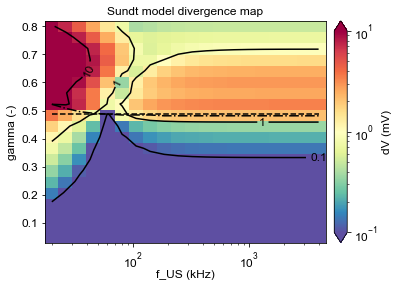

In [23]:
insets = [
    (30., 0.35),
    (30., 0.7),
    (60., 0.7),
    (70., 0.5),
    (200., 0.75),
    (500., 0.2),
    (700., 0.4),
    (700., 0.6)
]

plotDriveDivMap('Sundt', 10.0, insets=None)

### Save figures

In [16]:
figdir = input('figure output directory:')
for k, v in figs.items():
    v.savefig(os.path.join(figdir, f'{k}.pdf'), transparent=True)

figure output directory: C:\Users\lemaire\Desktop\sonic
